In [1]:
import json
import itertools
import pickle
import hickle 
import gzip
import operator
import os
import sys
from time import time
import pprint as pp
import collections
import ConfigParser

import numpy as np
import pandas as pd

import twitter

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib


# bokeh
import bokeh.plotting as bkplt


# import requirments 
from IPython.display import Image
from IPython.display import display
import matplotlib.pyplot as plt
import json
import rpy2
%load_ext rpy2.ipython
%R require("ggplot2")
% matplotlib inline
from ggplot import *
randn = np.random.randn

/Users/blehman/anaconda/lib/python2.7/site-packages/rpy2/robjects/robject.py:5: UserWarning: Loading required package: stats

  rpy2.rinterface.initr()
/Users/blehman/anaconda/lib/python2.7/site-packages/rpy2/robjects/robject.py:5: UserWarning: Loading required package: DBI

  rpy2.rinterface.initr()
/Users/blehman/anaconda/lib/python2.7/site-packages/rpy2/robjects/robject.py:5: UserWarning: Loading required package: rJava

  rpy2.rinterface.initr()
/Users/blehman/anaconda/lib/python2.7/site-packages/rpy2/robjects/robject.py:5: UserWarning: Error in .jcall(drv@jdrv, "Ljava/sql/Connection;", "connect", as.character(url)[1],  : 
  java.sql.SQLException: [Vertica][VJDBC](100176) Failed to connect to host localhost on port 5434. Reason: Connection refused

  rpy2.rinterface.initr()


### Setup & Creds
Let's grab some json records from Twitter's public api. 

We'll use python-twitter. 
<pre>
$ pip install python-twitter
$ pydoc twitter.Api
</pre>

Build an app [https://apps.twitter.com/](https://apps.twitter.com/).  

Then use the app info in the `config.cfg` file.
    

In [2]:
# read the config file.
config = ConfigParser.RawConfigParser()
config.read('myconfig.cfg')

# creds found in your Twitter app. See https://apps.twitter.com/
token = config.get('oauth','token')
token_secret = config.get('oauth','token_secret')
con_key = config.get('oauth','con_key')
con_secret_key = config.get('oauth','con_secret_key')

# setup 
api = twitter.Api(
    consumer_key=con_key
    , consumer_secret=con_secret_key
    , access_token_key = token
    , access_token_secret = token_secret)

# test creds
print "@{}".format(api.VerifyCredentials().GetScreenName())



@BrianLehman


In [15]:
# if False, then reuse previously sampled data.
# if True, then get new data.
run_ = False

if run_:
    # get ~5000 tweets from the public API.
    results = api.GetSearch(term = 'golden retriever', count = 100, include_entities=True)                
    counter = 1
    total_tweets = 5000
    tweets = []
    while counter <= total_tweets:
        if counter == 1:
            new_results = api.GetSearch(term = 'golden retriever'
                                        , count = 100
                                        , max_id = results[-1].GetId()
                                        , include_entities=True)
        else:
            new_results = api.GetSearch(term = 'golden retriever'
                                        , count = 100
                                        , max_id = new_results[-1].GetId()
                                        , include_entities=True)
        counter += len(new_results)
        tweets.extend(new_results)
    # store tweets
    tweet_text = [tweet.GetText() for tweet in tweets]
    print len(tweet_text)
    pickle.dump(tweet_text,open('./data/tweet_text.pkl','wb'))
    
else:
    # load example data
    tweet_text = pickle.load(open('./data/tweet_text.pkl','rb'))
    
    


5000


### Train/Test set
Split the training and test set.

In [16]:
# Set up a training and test set.

def create_index(total_tweets):
        """
        Builds an index for the training and test set.
        The sets serve as a list of row numbers to extract from the dataset. 
        """
        # based on the total tweet count, create an array of all line numbers 
        line_index = np.array(range(0,total_tweets))
        # split the array into training and test sets of index values
        trainIndex,testIndex = train_test_split(line_index,train_size=0.70, random_state=42)
        # save test & traning index values
        #np.save("training_index",trainIndex)
        #np.save("testing_index",testIndex)
        return trainIndex,testIndex
if run_:
    # build indicies 
    trainIndex,testIndex = create_index(len(tweet_text))
    pickle.dump(trainIndex,open('data/trainIndex.pkl','wb'))
    pickle.dump(testIndex,open('data/testIndex.pkl','wb'))

    # build test set
    test_tweets = [tweet_text[i] for i in testIndex]
    pickle.dump(test_tweets,open('data/test_tweets.pkl','wb'))

    train_tweets = [tweet_text[i] for i in trainIndex]
    pickle.dump(test_tweets,open('data/train_tweets.pkl','wb'))
    print "train: {:,}".format(len(train_tweets))
    print "test: {:,}".format(len(test_tweets))
else:
    trainIndex = pickle.load(open('data/trainIndex.pkl','rb'))
    testIndex = pickle.load(open('data/testIndex.pkl','rb'))
    test_tweets = pickle.load(open('data/test_tweets.pkl','rb'))
    train_tweets = pickle.load(open('data/train_tweets.pkl','rb'))


train: 3,500
test: 1,500


### Vectorize the Tweets
Two steps:  
1.  Set up a vectorizer.
2.  Vectorize the tweets to build the vocabulary.

In [13]:
# Set up a vecterizer.
# see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

def vectorize_1():
    vectorizer = TfidfVectorizer(#min_df=20
                                 stop_words='english'
                                 , use_idf=True # enable inverse-document-frequency reweighting
                                 , ngram_range=(1,2) # given our vocab, not really necessary
                                 , binary = True # presence of word instead of frequency
                                 #, vocabulary = vocab
                                ) 
    #X = vectorizer.fit_transform(tweet_list)
    return vectorizer

def vectorize_2(vocab):
    vectorizer = CountVectorizer(stop_words='english'
                                 , ngram_range=(1,2) # given our vocab, not really necessary
                                 , binary = True # presence of word instead of frequency
                                 , vocabulary = set(vocab)
                                ) 
    #X = vectorizer.fit_transform(tweet_list)
    return vectorizer


In [19]:
# Vectorize the tweets to build the vocabulary.
vectorizer = vectorize_1()
X = vectorizer.fit_transform(train_tweets)
shape = X.get_shape()
print "tweets: {:,}".format(X.get_shape()[0])
print "vocabulary terms: {:,}".format(X.get_shape()[1])

tweets: 3,500
vocabulary terms: 8,160


Progress (pre reduction):
* Total tweets: 3,500. 

* Total dimensions: __8,160__. 

### Dimension Reduction

To choose the appropriate number of svd components, we need to explore the amount of variance explained with each component. We'll reduce the number of components to 600. This number provides about 90% of the explained variance.  

In [27]:
#explained_variances = np.var(X_svd, axis=0) / np.var(X_train, axis=0).sum()
def create_svd_doc_term_matrix(X_train, num_eigen_vectors=100):
    """
    Create the array with truncated svd.
    """
    # Build the fuction to create the svd space
    svd = TruncatedSVD(n_components = num_eigen_vectors)
    # Apply normalization in place to each row of the data 
    pipeline = make_pipeline(svd, Normalizer(copy=False))
    return pipeline.fit_transform(X_train), svd

,components,explained_var
0,100,0.758546
1,150,0.787840
2,200,0.808351
3,250,0.826400
4,300,0.842720
5,350,0.858485
6,400,0.873053
7,450,0.887815
8,500,0.901834
9,550,0.914997


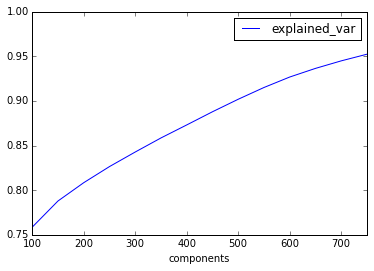

In [23]:
explained_variance_list = []
# The number of svd components to explore
svd_component_range = range(100,751,50)

# finds the explained variance for each number of components
for i in svd_component_range:
    # find explained variance (i in this case is the number of components to use)
    X_svd, svd = create_svd_doc_term_matrix(X,i)
    explained_variance_list.append(svd.explained_variance_ratio_.sum())

expVar = pd.DataFrame({'explained_var':explained_variance_list
                   , 'components':svd_component_range})
display(expVar)

display(expVar.plot(x='components',y='explained_var'))


Based on the above graphs, we see that about 500 of the svd components explains over 90% of the variance in the data set. 

In [25]:
X_svd, svd = create_svd_doc_term_matrix(X,500)
X_svd.shape

(3500, 500)

Progress (post reduction):
* Total tweets: 3,556. 

* Total dimensions: <s>8,160</s> __500__.   

### Create Cluster Centroids
We'll now apply kmeans to find the centroids that will be used to predict a cluster for each tweet.

In [28]:
def build_clusters(X_svd, k=5):
    """
    Use kmeans to find centroids.
    """
    km = KMeans(n_clusters=k
                , init='k-means++'
                , max_iter=100
                #, n_init=10
                , verbose=False)
    km.fit(X_svd)
    pred=km.predict(X_svd)
    pred_df=pd.DataFrame(pred)
    pred_df.columns=['pred_cluster']
    return km.cluster_centers_ , pred_df, k


Choosing k, the number of clusters, can involve much more analaysis than this tutorial is targeting. See [@jrmontag](https://twitter.com/jrmontag)'s insightful tutorial for more deatils: [choosing-k-in-kmeans](https://github.com/DrSkippy/Data-Science-45min-Intros/tree/master/choosing-k-in-kmeans).

In [71]:
# Choose number of clusters
my_k = 10

In [72]:
# Build centroids
centroids, predictions, n_clusters = build_clusters(X_svd, my_k)
pickle.dump(centroids, open('./data/centroids'+str(my_k)+'.pkl','wb'))
pickle.dump(predictions, open('./data/predictions'+str(my_k)+'.pkl','wb')) 

### Explore Word Loadings
Those tweets nearest the cluster centers are used as an approximation for their meanings.

In [73]:
word_loadings = np.dot(centroids, svd.components_)
pickle.dump(word_loadings,open('./data/word_loadings.pkl','wb'))
vocab = vectorizer.get_feature_names()
pickle.dump(vocab,open('./data/vocab.pkl','wb'))
for k in range(0,my_k):
    #word loadings = cluster_centers * eigenvectors 
    indices=[i for i in np.argsort(word_loadings[k,:])[::-1]]    
    sorted_vocab=[vocab[i] for i in indices]
    print("Top words for cluster {}:\n{}\n".format(k, sorted_vocab[:50]))

Top words for cluster 0:
[u'https jign6rxdr5', u'jign6rxdr5', u'retriever realizes', u'fit old', u'realizes fit', u'anymore', u'realizes', u'anymore https', u'fit', u'place anymore', u'old place', u'baby golden', u'babyanimalpics baby', u'place', u'rt babyanimalpics', u'babyanimalpics', u'baby', u'old', u'rt', u'https', u'golden retriever', u'retriever', u'golden', u'ijieehrwfu', u'https ijieehrwfu', u'sibjbgrf2r', u'https sibjbgrf2r', u'uikumrh5hu barbie', u'https uikumrh5hu', u'barbie', u'uikumrh5hu', u'retriever amp', u'babyanimalgifs husky', u'05326719029 denizz1905_ua', u'210', u'x16 210', u'loves owner', u'love like', u'kise', u'loves', u'knbnsfw kise', u'knbnsfw', u'kise love', u'retriever loves', u'rt knbnsfw', u'im dying', u'vlf9gzu23k', u'http vlf9gzu23k', u'cooitweetshere', u'cooitweetshere husky']

Top words for cluster 1:
[u'omwuces4sh', u'art golden', u'showmethecraft', u'dog art', u'https fsq98bcquk', u'vyaart https', u'showmethecraft dog', u'vyaart', u'fsq98bcquk', u'do

### Label New Tweets
Apply the model to the test set.

In [74]:
def label_tweets(vectorizer, word_loadings, testing_data, sample_percentage=0.20):
    """
    Label tweets.
    """
    result = []
    sample_size = int(len(testing_data)*sample_percentage)
    sample_tweets = testing_data[:sample_size]
    for tweet in sample_tweets:
        # vectorize the tweet
        sparse_array = vectorizer.fit_transform([tweet])
        # subtract all values between the tweet vectorization and centroids
        sparse_array_subtraction_abs = np.absolute(sparse_array - word_loadings)
        # sum to get the total distances 
        sparse_array_subtraction_abs_sum = sparse_array_subtraction_abs.sum(axis=1)
        # append the index of the minimum distance
        result.append(np.argmin(sparse_array_subtraction_abs_sum))
    return result

In [75]:
#test_vectorizer = vectorize_2(vocab)

In [76]:
class TopicModel():
    """
    Topic clusters built from 2012 soda rules, SVD applied, kmeans for centroids. New tweets
    are labled by their nearness to centroids.
    """
    def __init__(self):
        """
        Load and initialize any external models or data here.
        """
        self.word_loadings = pickle.load(open('./data/word_loadings.pkl'))
        self.vocab = pickle.load(open('./data/vocab.pkl'))
        self.vectorizer = CountVectorizer(stop_words='english'
                                          , ngram_range = (1,2)
                                          , binary = True # presence of word instead of frequency
                                          , vocabulary = self.vocab
                                         )
        self.tweets = pickle.load(open('./data/test_tweets.pkl')) 
    def enrichment_value(self):
        """
        Calculates the nearest cluster for an unlabeled tweet using the vocab and cluster centers from the training set.
        """
        tweetTxt = self.tweets
        # vectorize the tweet
        sparse_array = self.vectorizer.fit_transform(tweetTxt).toarray()
        for item in sparse_array:
            # multiply the weights by the vector
            weighted_sparse_array = item * self.word_loadings
            # dot product to find the sum of the token weights for this specific tweet
            sums = [np.dot(item,row) for row in self.word_loadings]
            # return the following
            result = {
                    "clusterID": np.argmax(sums)
                    , "min_score": np.min(sums)
                    , "max_score": np.max(sums)
                    , "mean_score": np.mean(sums)
                    , "stdev_score": np.std(sums)
                    }
            yield result
    def __repr__(self):
        """ Add a description of the class's function here """
        return("Topic clusters built from 2012 soda rules Tweets are vectorized using CountVectorizer to icludes 2grams in the vocab. \
                The 50 topic clusters are built from 2012 data soda rules, SVD applied, \
                kmeans for centroids. New tweets are labled by their nearness to centroids.Result returned provides score information.")


In [77]:
# Create instance of model and label tweets
model = TopicModel()
test_data = model.enrichment_value()
clusterID_list = [data['clusterID'] for data in test_data]
clusterID_df = pd.DataFrame(data=clusterID_list,columns=['clusterID'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122c57a90>]], dtype=object)

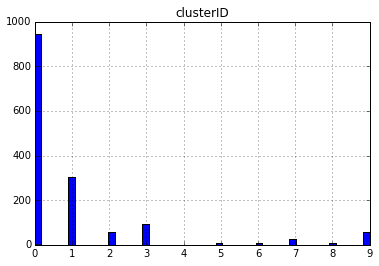

In [78]:
# review clusterID distribution 
clusterID_df.hist(bins=50)